<a href="https://colab.research.google.com/github/nicxs3/nutriBERT/blob/main/nutriBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal:
Predict the carbohydrate content of a meal based on its natural language description, using machine learning models trained on a labeled dataset

Variations Used:

1. TF-IDF + Ridge Regression
- Converts text into sparse numerical vectors using term frequency-inverse document frequency (TF-IDF)
- Uses Ridge (L2-regularized) regression to predict carbs

2. Sentence-BERT + MLP
- Uses pre-trained Sentence-BERT embeddings for meal descriptions
- Feeds those into a Multi-Layer Perceptron (MLP) for regression
3. Fine-tuned BERT Regressor
- A custom BERT model trained end-to-end to directly predict carb values
- Utilizes BertModel and adds a regression head
- Trained using L1 loss (Mean Absolute Error) and saved using torch.save(...)

Variation 1 - TF-IDF + Ridge Regression:

In [ ]:
!pip install transformers sentence-transformers scikit-learn

In [ ]:
import pandas as pd

train_df = pd.read_csv("/train.csv")
val_df = pd.read_csv("/val.csv")
test_df = pd.read_csv("/test.csv")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df["query"])
X_val = vectorizer.transform(val_df["query"])

model = Ridge()
model.fit(X_train, train_df["carb"])
preds = model.predict(X_val)

mae = mean_absolute_error(val_df["carb"], preds)
print("Validation MAE:", mae)


Used TF-IDF for preprocessing and a Ridge Regression model, Validation MAE: 14.7717

Variation 2 - Sentence-BERT + MLP

In [ ]:
!pip install -q sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error


In [ ]:
# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode text descriptions into 384-dimensional vectors
X_train = model.encode(train_df['query'].tolist())
X_val = model.encode(val_df['query'].tolist())

mlp = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp.fit(X_train, train_df['carb'])

preds = mlp.predict(X_val)
mae = mean_absolute_error(val_df['carb'], preds)
print("Validation MAE:", mae)


Sentence-BERT for preprocessing and MLP model, Valdiation MAE: 9.8682

Variation 3 - Fine-tuned BERT Regressor:

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch

In [ ]:
import pandas as pd

train_df = pd.read_csv('/train.csv')
val_df = pd.read_csv('/val.csv')

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["query"], padding="max_length", truncation=True, max_length=64)



In [ ]:
from torch.utils.data import Dataset

class NutriDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.encodings = tokenizer(df["query"].tolist(), truncation=True, padding="max_length", max_length=64)
        self.labels = df["carb"].tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
from torch.utils.data import DataLoader

train_dataset = NutriDataset(train_df, tokenizer)
val_dataset = NutriDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
from transformers import BertModel
import torch.nn as nn

class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.regressor(cls_output).squeeze(-1)


In [ ]:
from torch.optim import AdamW
import torch

model = BertRegressor()
model.to("cuda")

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.L1Loss()  # MAE Loss

for epoch in range(20):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["labels"].to("cuda")
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_mae = mean_absolute_error(val_labels, val_preds)
    print(f"Epoch {epoch+1}: Validation MAE = {val_mae:.4f}")

torch.save(model, "full_model.pt")


In [ ]:
from sklearn.metrics import mean_absolute_error

model = torch.load("full_model.pt", weights_only=False)
model.to("cuda")
model.eval()
preds, targets = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds.extend(outputs.cpu().numpy())
        targets.extend(labels.cpu().numpy())

mae = mean_absolute_error(targets, preds)
print("Validation MAE:", mae)


at 5 epochs MAE: 10.46 --
at 10 epochs MAE: 8.726 --
at 20 epochs MAE: 7.0649


In [ ]:
mae_values = [
    14.0509, 12.7274, 11.5398, 10.9161, 10.5559,
    9.6476, 9.3707, 9.2629, 8.7126, 8.6234,
    8.2747, 8.0455, 7.8250, 7.6647, 7.4687,
    7.5083, 7.1884, 7.0454, 7.0130, 7.0650
]

import matplotlib.pyplot as plt

epochs = list(range(1, len(mae_values) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, mae_values, marker='o', linestyle='-', linewidth=2)
plt.title("Validation MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.xticks(epochs)
plt.show()


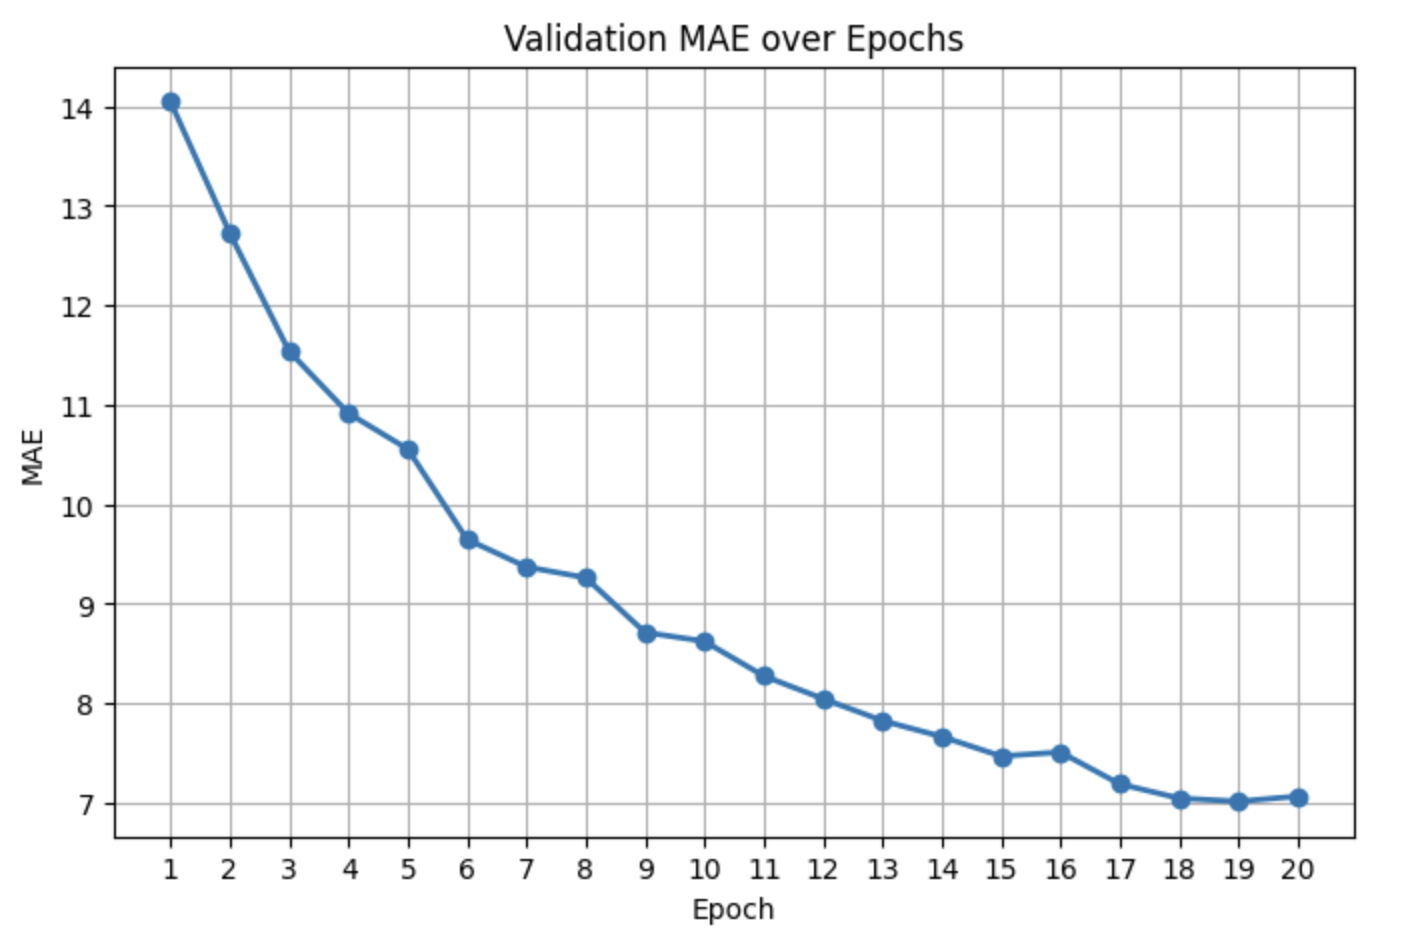

Running Fine-tuned BERT Regressor on test dataset...

In [ ]:
test_df = pd.read_csv("/test.csv")

test_encodings = tokenizer(
    test_df["query"].tolist(),
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)


In [ ]:
from torch.utils.data import DataLoader, Dataset

class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

test_dataset = TestDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
model = torch.load("full_model.pt", weights_only=False)
model.to("cuda")
model.eval()

predicted_carbs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_carbs.extend(outputs.cpu().numpy())

test_df["predicted_carb"] = predicted_carbs

test_df.to_csv("nutribench_test_with_predictions.csv", index=False)


Summary:

In the NutriBench project, the goal was to predict the carbohydrate content of meals based on natural language descriptions. Three different model variations were implemented and evaluated. The first approach used TF-IDF vectorization combined with Ridge Regression, which offered a simple and fast baseline but lacked semantic understanding, resulting in a validation MAE of approximately 14.77. The second approach used pre-trained Sentence-BERT embeddings as input to a Multi-Layer Perceptron (MLP), improving semantic representation and achieving a lower validation MAE of around 9.86. The best-performing model was a fine-tuned BERT regressor trained end-to-end on the task. Over 20 epochs, the BERT model’s validation MAE steadily decreased from 14.05 in epoch 1 to a final value of approximately 7.06 by epoch 20, demonstrating effective learning. After training, predictions were generated on the test set, added as a new column to the dataframe, and exported as a CSV file for further analysis.

Example Predicted Carbs (grams) using the Fine-tuned BERT Regressor:

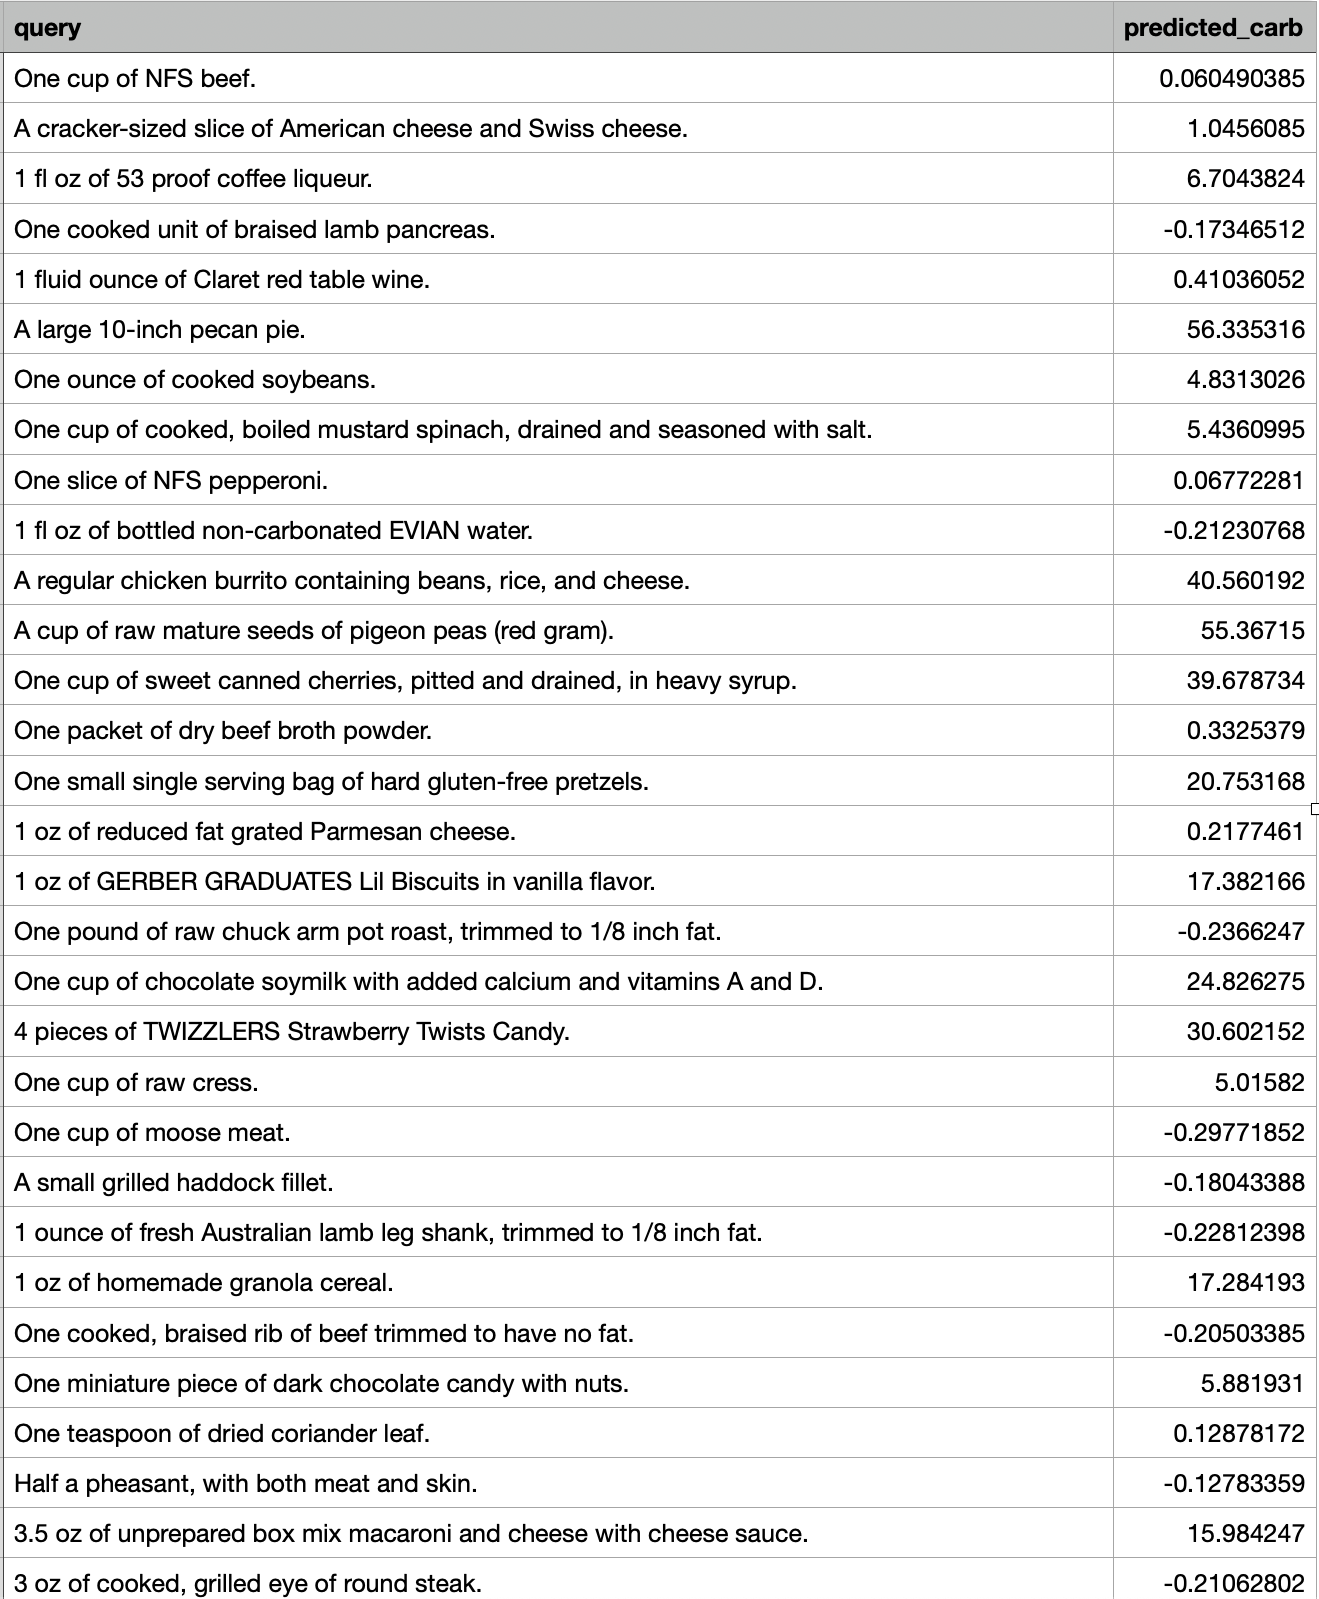